In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import os.path
from os.path import exists
from unyt import mass_hydrogen_cgs, eV, erg, Msun, s, Myr
from bisect import bisect
yt.enable_plugins()
yt.enable_parallelism()

yt : [INFO     ] 2023-01-31 10:03:05,455 Loading plugins from /home/dskinner6/.config/yt/my_plugins.py


False

In [6]:
run_dir = '../'
data_dir = 'run_data/'
image_outputs = 'images/'

tiny_number = 1e-30

stars = ['p3_age', 'p3_binary', 'ns_binary', 'bh', 'p2', 'dm']
types = [5, 12, 13, 6, 7, 1]

kph_fields = [('enzo', 'HI_kph'), ('enzo', 'HeI_kph'), ('enzo', 'HeII_kph')]
weights = ['density', 'ones', 'cell_mass']

res = 1000
width = (10, 'kpc')

In [16]:
limits = False
if limits == True:
    out_dir = "limits"
else:
    out_dir = "no_limits"
    
with open('run_DD_data.json') as f:
    DD_data = json.load(f)

with open('param_info.json') as f:
    param_info = json.load(f)

with open('massive_prog_info.json') as f:
    massive_prog = json.load(f)

with open('run_halos.json') as f:
    run_halos = json.load(f)

runs = ['run_original', 'run_fiducial', 'run_A', 'run_B', 'run_D', 'run_E']

dataset_list = []
for i, run_name in enumerate(runs):
    if run_name == 'run_original':
        for j, o in enumerate(massive_prog):
            dataset_list.append(f'{run_dir}{run_name}/DD{o}/output_{o}')
                
    else:
        for j, o in enumerate(run_halos[run_name]):
            dataset_list.append(f'{run_dir}{run_name}/DD{o}/output_{o}')

fns = yt.DatasetSeries(dataset_list)

In [19]:
ds = fns[-1]

yt : [INFO     ] 2023-01-31 10:09:17,111 Parameters: current_time              = 88.44306507624
yt : [INFO     ] 2023-01-31 10:09:17,112 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2023-01-31 10:09:17,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-31 10:09:17,113 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-01-31 10:09:17,113 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-01-31 10:09:17,114 Parameters: current_redshift          = 10
yt : [INFO     ] 2023-01-31 10:09:17,114 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2023-01-31 10:09:17,114 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2023-01-31 10:09:17,114 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-01-31 10:09:17,115 Parameters: hubble_constant           = 0.6766


In [20]:
halo_rad = {}
for ds in fns.piter(sto = halo_rad, dynamic=True):
    run_name = str(ds.directory).split('/')[-2]
    o = str(ds).split('output_')[-1]
    
    temp_dict = {}
    temp_dict[run_name] = {}
    temp_dict[run_name][o] = {}
    
    if run_name == 'run_original':
        halo_pos = ds.arr(massive_prog[o]['position'], 'unitary').to('kpc')
        halo_rvir = ds.quan(massive_prog[o]['rvir'], 'unitary').to('kpc')

    else:
        halo_pos = ds.arr(run_halos[run_name][o]['position'], 'unitary').to('kpc')
        halo_rvir = ds.quan(run_halos[run_name][o]['rvir'], 'unitary').to('kpc')


    sp = ds.sphere(halo_pos, halo_rvir)
    
    for field in kph_fields:
        temp_dict[run_name][o][field] = {}
        tot_val = sp.quantities.total_quantity(field).to('1/s').v.tolist()
        temp_dict[run_name][o][field]['total'] = tot_val
        
        img_name = f'{data_dir}projection_{field[1]}_{run_name}_{o}.npy'
        
        if exists(img_name) == False:
            prj = yt.ProjectionPlot(ds, 'x', field, center = halo_pos, weight_field = 'ones')
            prj.set_unit(field, '1/s')
            frb = prj.data_source.to_frb(width, res)
            with open(img_name, 'wb') as f:
                np.save(f, np.array(frb[field]))
            del prj
            del frb
        else:
            print(f'{img_name} created.')
        
        for weight in weights:
            value = sp.quantities.weighted_average_quantity(field, weight).to('1/s').v.tolist()
            temp_dict[run_name][o][field][weight] = value
            
            
    sto.result_id = f'{run_name}_{o}'
    sto.result = temp_dict
    
    
    
    

Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████████████████| 1184/1184 [00:00<00:00, 5418.84it/s]
yt : [INFO     ] 2023-01-31 10:09:37,184 Gathering a field list (this may take a moment.)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(*field)
/home/dskinner6/software/yt-conda/envs/yt_analysis/lib/python3.10/site-packages/yt/fields/field_detector.py:108: VisibleDeprecationWarning: The requested field name 'y' is ambiguous and corresponds to any one of the following field types:
 {'enzo', 'gas'}
Please specify the requested field as an explicit tuple

In [21]:
sp.quantities.total_quantity(kph_fields[1])

unyt_quantity(6.18779447e+11, '1/code_time')

In [23]:
sp.quantities.weighted_average_quantity(kph_fields[1], 'density')

unyt_quantity(78151.16606879, '1/code_time')

In [25]:
sp.quantities.weighted_average_quantity(kph_fields[1], 'cell_mass')

unyt_quantity(105329.51494418, '1/code_time')

yt : [INFO     ] 2023-01-31 10:21:20,149 Projection completed
yt : [INFO     ] 2023-01-31 10:21:20,150 xlim = 0.445000 0.555000
yt : [INFO     ] 2023-01-31 10:21:20,150 ylim = 0.445000 0.555000
yt : [INFO     ] 2023-01-31 10:21:20,151 xlim = 0.445000 0.555000
yt : [INFO     ] 2023-01-31 10:21:20,151 ylim = 0.445000 0.555000
yt : [INFO     ] 2023-01-31 10:21:20,152 Making a fixed resolution buffer of (('enzo', 'HeI_kph')) 800 by 800



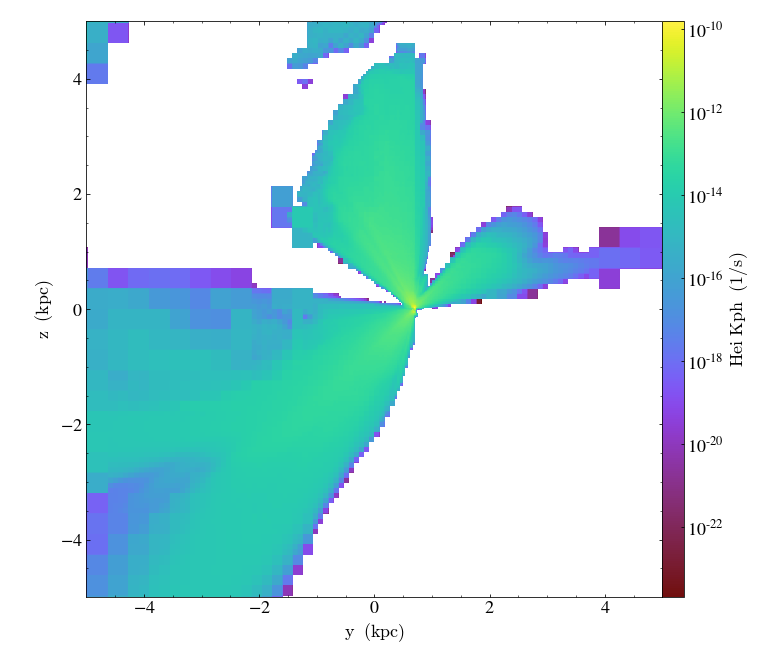

In [27]:
prj = yt.ProjectionPlot(ds, 'x', kph_fields[1], width = (10, 'kpc'), weight_field = 'ones')
prj.set_unit(kph_fields[1], '1/s')
prj.show()